# Skin Cancer

#### Getting data ready

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#!/bin/bash
!kaggle datasets download sallyibrahim/skin-cancer-isic-2019-2020-malignant-or-benign

Dataset URL: https://www.kaggle.com/datasets/sallyibrahim/skin-cancer-isic-2019-2020-malignant-or-benign
License(s): unknown


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('skin-cancer-isic-2019-2020-malignant-or-benign.zip', 'r')
zip_ref.extractall('/content/Pre_Dataset')
zip_ref.close()
print("Dataset Loaded")

Dataset Loaded


### Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Modules & Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import matplotlib.image as mpimg

from scipy import stats
from sklearn.manifold import TSNE
from skimage import exposure
from skimage.filters import gaussian
from skimage.feature import canny
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from skimage.restoration import denoise_bilateral
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers,models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adamax
from tensorflow.keras.applications import VGG16,DenseNet121,ResNet50V2
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications import EfficientNetB4,EfficientNetB7,EfficientNetB3,InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, Activation, GlobalAveragePooling2D, BatchNormalization, Input

import os
import math
import shutil
from pathlib import Path
from PIL import Image
import imutils
import cv2
import glob
import pickle
import random
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Original Dataset count for all Directory

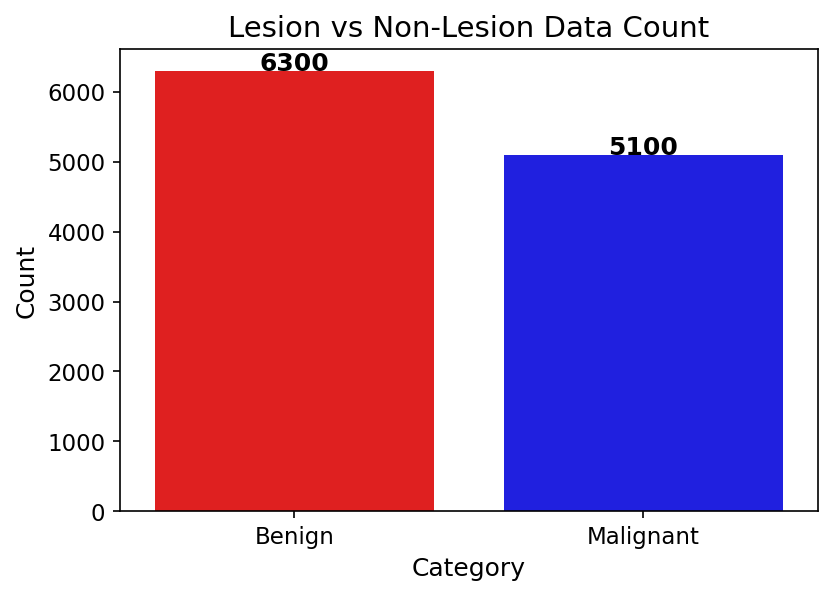

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
categories = ['Benign', 'Malignant']
counts = [(len(os.listdir('/content/Pre_Dataset/skin_dataset_resized/train_set/benign'))+ len(os.listdir('/content/Pre_Dataset/skin_dataset_resized/test_set/benign')) +
           len(os.listdir('/content/Pre_Dataset/skin_dataset_resized/val_set/benign'))),

          (len(os.listdir('/content/Pre_Dataset/skin_dataset_resized/train_set/malignant')) + len(os.listdir('/content/Pre_Dataset/skin_dataset_resized/test_set/malignant'))) +
          len(os.listdir('/content/Pre_Dataset/skin_dataset_resized/val_set/malignant'))]

# Plot
plt.figure(figsize=(6, 4), dpi=150)
ax = sns.barplot(x=categories, y=counts, palette=['red', 'blue'])

for i, count in enumerate(counts):
    plt.text(i, count + 2, str(count), ha='center', fontsize=12, fontweight='bold')

# Labels and Title
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Lesion vs Non-Lesion Data Count', fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.show()


# Combining all to a Dataset from train test and validation

In [ ]:
import os
import shutil

# source directories
source_dirs = [
    "/content/Pre_Dataset/skin_dataset_resized/train_set",
    "/content/Pre_Dataset/skin_dataset_resized/test_set",
    "/content/Pre_Dataset/skin_dataset_resized/val_set"
]

# target directory
target_dir = "/content/Dataset"

# target directories
os.makedirs(os.path.join(target_dir, "benign"), exist_ok=True)
os.makedirs(os.path.join(target_dir, "malignant"), exist_ok=True)

for source in source_dirs:
    for category in ["benign", "malignant"]:
        source_path = os.path.join(source, category)
        target_path = os.path.join(target_dir, category)

        if os.path.exists(source_path):
            for img in os.listdir(source_path):
                src_img_path = os.path.join(source_path, img)
                dst_img_path = os.path.join(target_path, img)

                # Move image
                shutil.move(src_img_path, dst_img_path)

print("Dataset restructured successfully!")


Dataset restructured successfully!


# Undersampling to 5100 each class



In [ ]:

def undersample_dataset(dataset_path, output_path):
  # Class folder names and desired number of images
  class_folders = ['benign', 'malignant']
  target_count = 5100

  # Create output directory if it doesn't exist
  os.makedirs(output_path, exist_ok=True)

  # Process each class folder
  for class_folder in class_folders:
      class_path = os.path.join(dataset_path, class_folder)
      output_class_path = os.path.join(output_path, class_folder)

      os.makedirs(output_class_path, exist_ok=True)

      # List all image files in the class folder
      image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

      # Shuffle and select images if the count exceeds the target
      if len(image_files) > target_count:
          random.shuffle(image_files)
          selected_images = image_files[:target_count]
      else:
          selected_images = image_files  # Keep all if below target count

      # Copy selected images to the output folder
      for image in selected_images:
          shutil.copy(os.path.join(class_path, image), os.path.join(output_class_path, image))

  print(f"Undersampled dataset created at: {output_path}")



In [ ]:
dataset_path = '/content/Dataset'
output_path = '/content/dataset'
undersample_dataset(dataset_path,output_path)

Undersampled dataset created at: /content/dataset


In [ ]:
print(len(os.listdir('/content/dataset/benign')))


5100


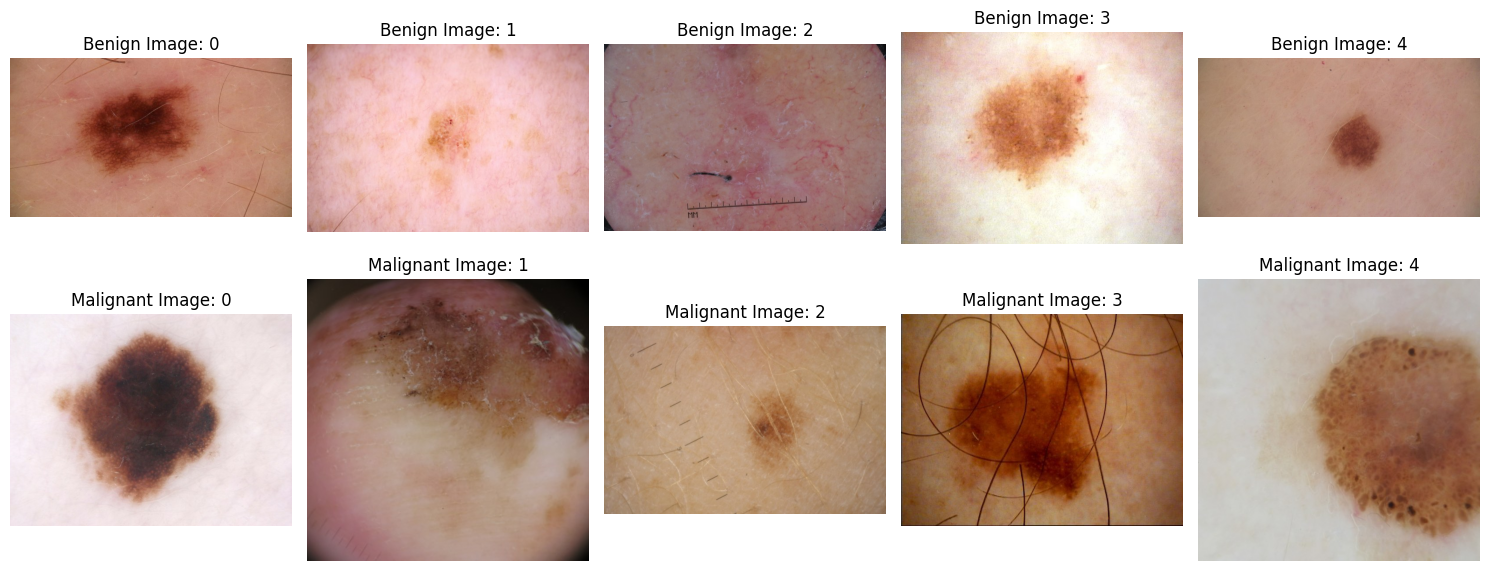

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2

# Define paths
Benign = "/content/Dataset/benign"
Malignant = "/content/Dataset/malignant"

# Function to load images
def load_images_from_folder(folder, num_images=5):
    images = []
    filenames = os.listdir(folder)[:num_images]  # Select first 'num_images'
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            images.append((img, filename))
    return images

# Load images
Benign_Img = load_images_from_folder(Benign, num_images=5)
Malignant_Img = load_images_from_folder(Malignant, num_images=5)

# Plot images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns

for i, (img, fname) in enumerate(Benign_Img):
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Benign Image: {i}")
    axes[0, i].axis("off")

for i, (img, fname) in enumerate(Malignant_Img):
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Malignant Image: {i}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


# Model

# Initial Parameters

In [ ]:
image_h = 224
image_w = 224
BATCH = 32
EPOCH = 30
classes = 2
channels = 3
image_h,image_w

(224, 224)

In [ ]:
dataset_folder = '/content/dataset'


labels = ['benign', 'malignant']

list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(dataset_folder, label, "*")
    image_files = glob.glob(label_path)

    sign_label = [label] * len(image_files)


    list_path.extend(image_files)
    list_labels.extend(sign_label)

dataframe = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})


In [ ]:
dataframe

,image_path,label
0,/content/dataset/benign/ISIC_9823318_640x360.jpg,benign
1,/content/dataset/benign/ISIC_6517082_640x480.jpg,benign
2,/content/dataset/benign/ISIC_7308784_640x360.jpg,benign
3,/content/dataset/benign/ISIC_3603821_640x427.jpg,benign
4,/content/dataset/benign/ISIC_7332892_640x360.jpg,benign
...,...,...
10191,/content/dataset/malignant/ISIC_0026239_640x48...,malignant
10192,/content/dataset/malignant/ISIC_0064742_480x48...,malignant
10193,/content/dataset/malignant/ISIC_0069386_480x48...,malignant
10194,/content/dataset/malignant/ISIC_0073065_480x48...,malignant


In [ ]:
dataframe.count()

,0
image_path,10196
label,10196


### Image Dimension

In [ ]:
width_dim = []
height_dim = []

def get_dimension():
    sub_dataset_path = f"/content/Dataset"
    letters = os.listdir(sub_dataset_path)

    for letter in letters:
        letter_path = os.path.join(sub_dataset_path, letter)

        for image in os.listdir(letter_path):

            image_path = os.path.join(letter_path, image)
            img = mimg.imread(image_path)
            d1, d2, colors = img.shape

            width_dim.append(d1)
            height_dim.append(d2)

get_dimension()


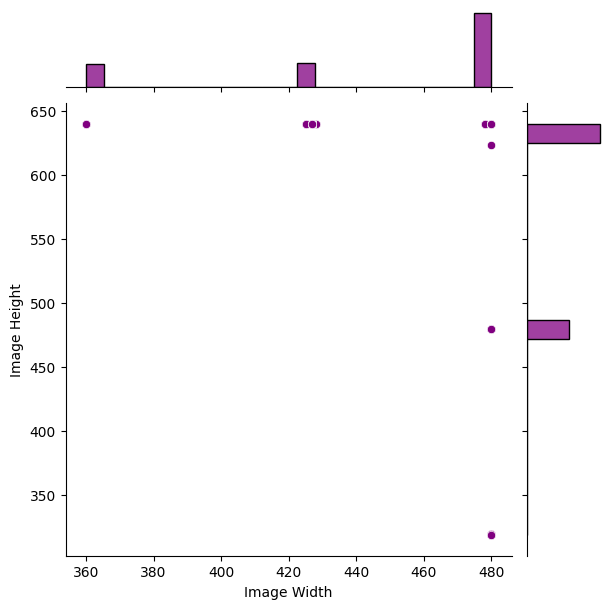

In [ ]:
sns.jointplot(x=width_dim, y=height_dim, color='purple')
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.show()

### Data Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    dataframe["image_path"],
    dataframe["label"],
    test_size=0.15,
    random_state=2024,
    shuffle=True,
    stratify = dataframe["label"]
)

train_df = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    train_df["image_path"], train_df["label"],
    test_size=0.15,
    random_state=2024,
    shuffle=True,
    stratify=train_df["label"]
)
train_df = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
val_df = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
test_df = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})


### Img datagen

In [ ]:
datagen = ImageDataGenerator(
    rescale=1/255.,
    # rotation_range=45,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # vertical_flip=True ,
    # brightness_range=[0.8, 1.2] , # Adjust brightness
    # fill_mode='nearest'
)
# Training Dataset
train_gen = datagen.flow_from_dataframe(
    train_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    target_size=(image_h,image_w),  # 256,256
    batch_size=BATCH
)

# Testing Dataset
test_gen = datagen.flow_from_dataframe(
    test_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    target_size=(image_h,image_w),  # 256,256
    batch_size=BATCH,
    shuffle=False
)
# Validation Dataset
val_gen = datagen.flow_from_dataframe(
    val_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    target_size=(image_h,image_w),  # 256,256
    batch_size=BATCH
)




Found 7366 validated image filenames belonging to 2 classes.
Found 1530 validated image filenames belonging to 2 classes.
Found 1300 validated image filenames belonging to 2 classes.


In [1]:
print(7366/2)

3683.0


In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

# CallBacks

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss',
#                               min_delta=0.01,
#                               patience=15,
#                               restore_best_weights=True,
#                               verbose=True)

# reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
#                                         patience=7,
#                                         factor=0.05,
#                                         verbose=True)

# checkpoint = ModelCheckpoint('best_weights.keras', save_best_only=True, monitor='val_accuracy', mode='max')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                              patience=5,
                              restore_best_weights=True,
                              verbose=False)

def scheduler(epoch, lr):
    decay = -0.1
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * math.exp((epoch + 1) * decay))

lrscheduler = LearningRateScheduler(scheduler)

checkpoint = ModelCheckpoint(
    "model_checkpoint.keras",
    monitor="val_loss",
    verbose=False,
    save_best_only=True,
    mode="auto",
)

callbacks = [checkpoint, lrscheduler, early_stopping]

#Models

### Efficient-Net-B3

# Using 5100 Dataset

In [ ]:
# EfficientNet
base_model = EfficientNetB3(
    weights='imagenet',
    include_top=False,
    input_shape=(image_h, image_w, 3),
    pooling='max'
)

eff_model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation= 'relu'),
    Dropout(0.3),
    Dense(2, activation= 'softmax',kernel_regularizer= l2(1e-4),name="softmax")
])

eff_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,183,665 (42.66 MB)

 Trainable params: 11,093,290 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [ ]:
# Compile the model
eff_model.compile(Adamax(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])


eff_model.fit(
    train_gen,
    # steps_per_epoch=train_gen.samples // BATCH,
    validation_data=val_gen,
    # validation_steps=val_gen.samples // BATCH,
    epochs=EPOCH,
    callbacks=callbacks,
    verbose=True
)

Epoch 1/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 244s 572ms/step - accuracy: 0.7535 - loss: 0.5504 - val_accuracy: 0.5162 - val_loss: 1.1668 - learning_rate: 1.0000e-04
Epoch 2/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 65s 281ms/step - accuracy: 0.8789 - loss: 0.3098 - val_accuracy: 0.6662 - val_loss: 0.7177 - learning_rate: 1.0000e-04
Epoch 3/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 65s 281ms/step - accuracy: 0.9072 - loss: 0.2491 - val_accuracy: 0.7685 - val_loss: 0.6237 - learning_rate: 1.0000e-04
Epoch 4/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 65s 282ms/step - accuracy: 0.9150 - loss: 0.2189 - val_accuracy: 0.8208 - val_loss: 0.4649 - learning_rate: 1.0000e-04
Epoch 5/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 65s 280ms/step - accuracy: 0.9205 - loss: 0.1947 - val_accuracy: 0.8346 - val_loss: 0.4221 - learning_rate: 1.0000e-04
Epoch 6/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 65s 279ms/step - accuracy: 0.9289 - loss: 0.1761 - val_accuracy: 0.8908 - val_loss: 0.3175 - learning_rate: 5.4881e-05
Epoch 7/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 66s 2

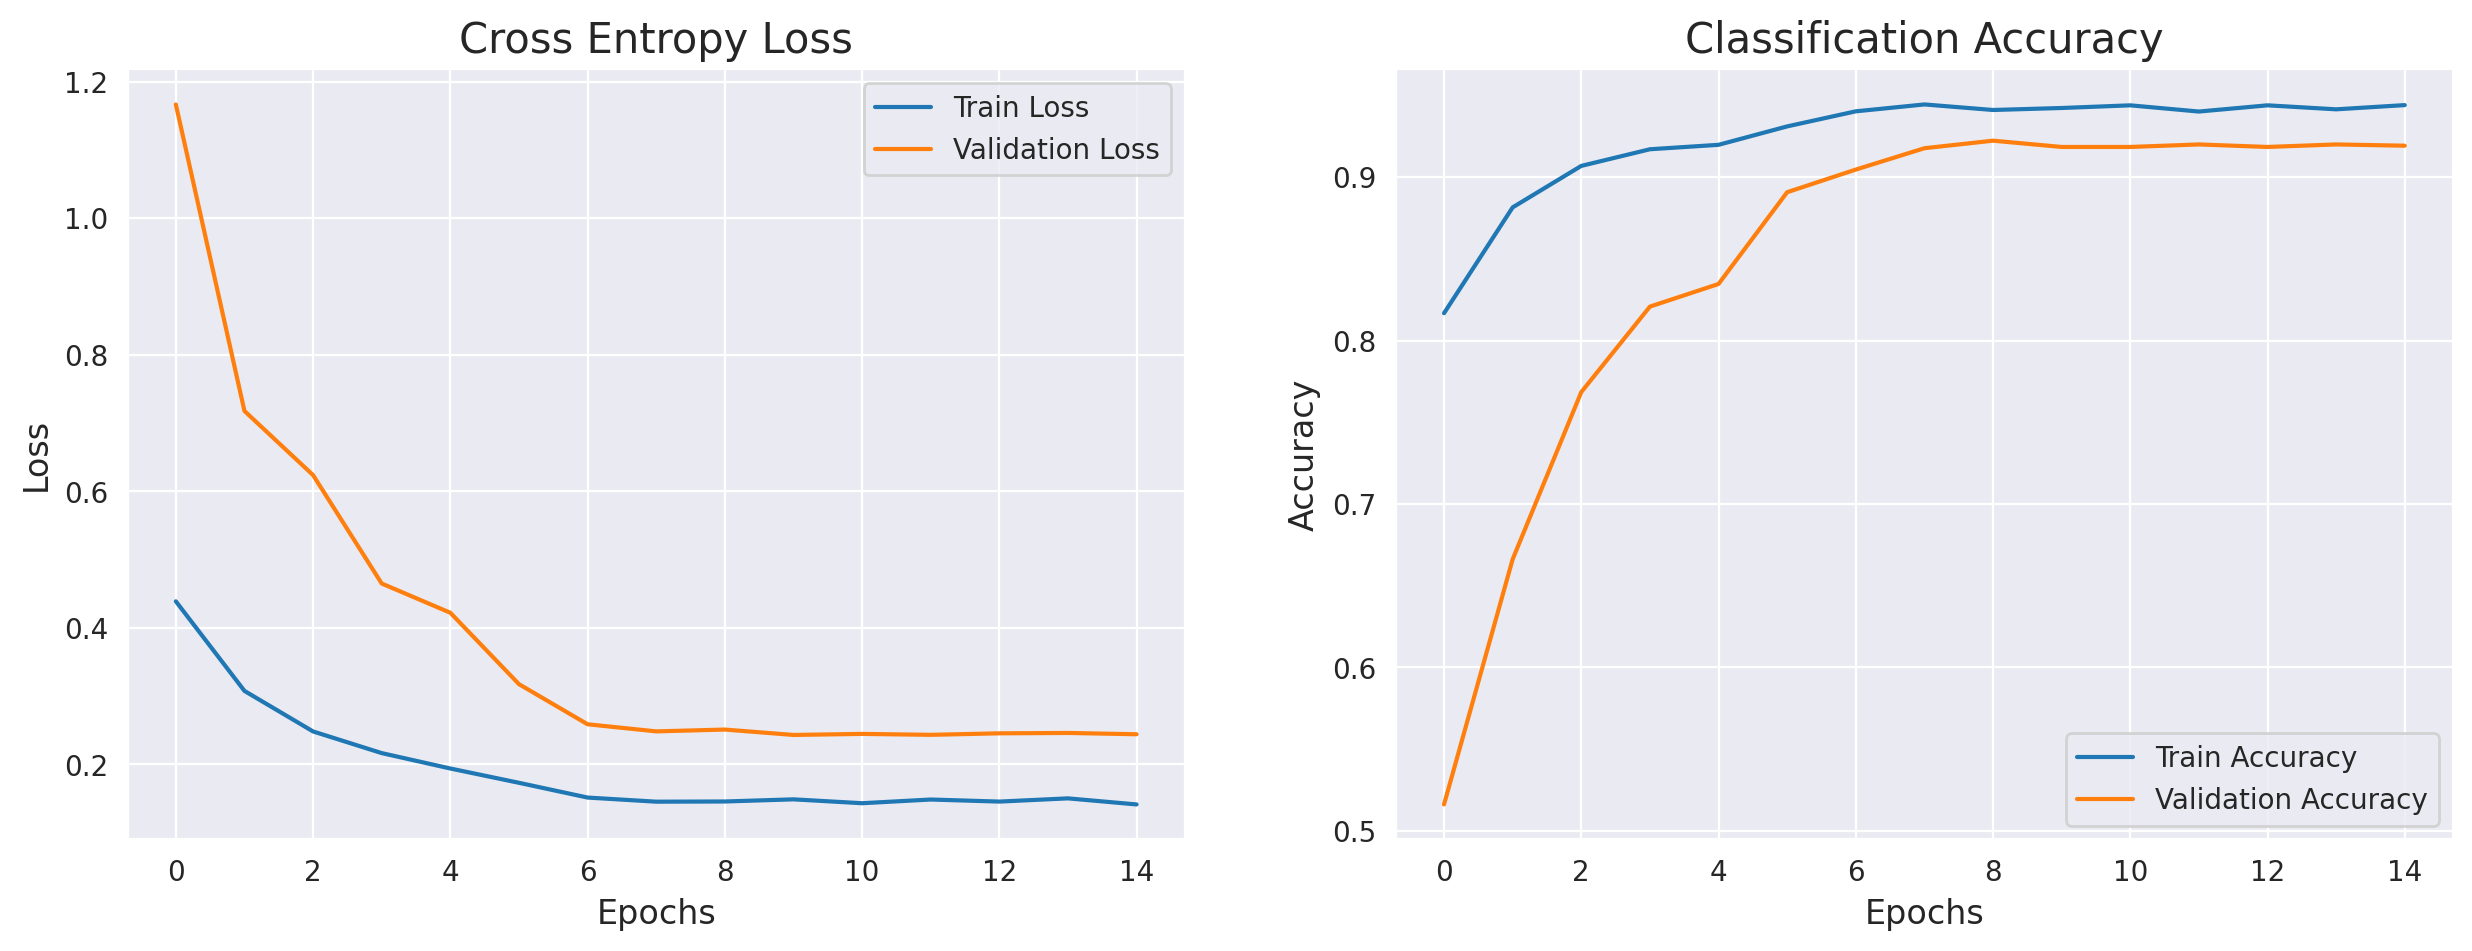


Model Testing 

The accuracy of the model for testing data is: 90.84967374801636
The Loss of the model for testing data is: 0.230707049369812
Correct predicted classes: 1390
Incorrect predicted classes: 140

Classification Report 

              precision    recall  f1-score   support

      benign       0.90      0.93      0.91       765
   malignant       0.92      0.89      0.91       765

    accuracy                           0.91      1530
   macro avg       0.91      0.91      0.91      1530
weighted avg       0.91      0.91      0.91      1530

Confusion Matrix 



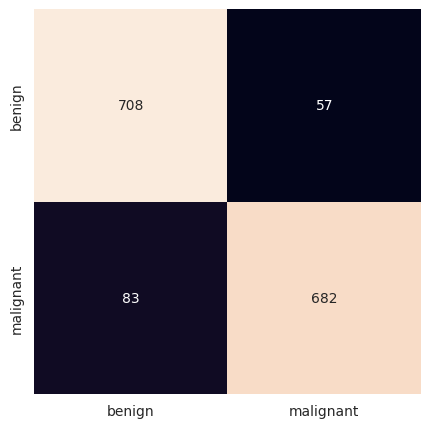

In [ ]:
all_evaluation(eff_model)

# For both 4000 and 5000 dataset model gives almost similar test accuracy. But with more data trained model indeed learns more.

# using 4000 Dataset

In [ ]:
# EfficientNet
base_model = EfficientNetB3(
    weights='imagenet',
    include_top=False,
    input_shape=(image_h, image_w, 3),
    pooling='max'
)
eff_
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation= 'relu'),
    Dropout(0.2),
    Dense(2, activation= 'softmax',kernel_regularizer= l2(1e-3),name="softmax")
])

eff_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,183,665 (42.66 MB)

 Trainable params: 11,093,290 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [ ]:
# Compile the model
eff_model.compile(Adamax(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])


eff_model.fit(
    train_gen,
    # steps_per_epoch=train_gen.samples // BATCH,
    validation_data=val_gen,
    # validation_steps=val_gen.samples // BATCH,
    epochs=EPOCH,
    callbacks=callbacks,
    verbose=True
)

Epoch 1/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 246s 700ms/step - accuracy: 0.7886 - loss: 0.5128 - val_accuracy: 0.5069 - val_loss: 1.6537 - learning_rate: 1.0000e-04
Epoch 2/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.8897 - loss: 0.2833 - val_accuracy: 0.6137 - val_loss: 0.9188 - learning_rate: 1.0000e-04
Epoch 3/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 286ms/step - accuracy: 0.9036 - loss: 0.2403 - val_accuracy: 0.7618 - val_loss: 0.6602 - learning_rate: 1.0000e-04
Epoch 4/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 51s 283ms/step - accuracy: 0.9263 - loss: 0.1885 - val_accuracy: 0.8255 - val_loss: 0.5188 - learning_rate: 1.0000e-04
Epoch 5/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 285ms/step - accuracy: 0.9274 - loss: 0.1834 - val_accuracy: 0.8412 - val_loss: 0.4533 - learning_rate: 1.0000e-04
Epoch 6/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 82s 286ms/step - accuracy: 0.9376 - loss: 0.1579 - val_accuracy: 0.9069 - val_loss: 0.2619 - learning_rate: 5.4881e-05
Epoch 7/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 54s 2

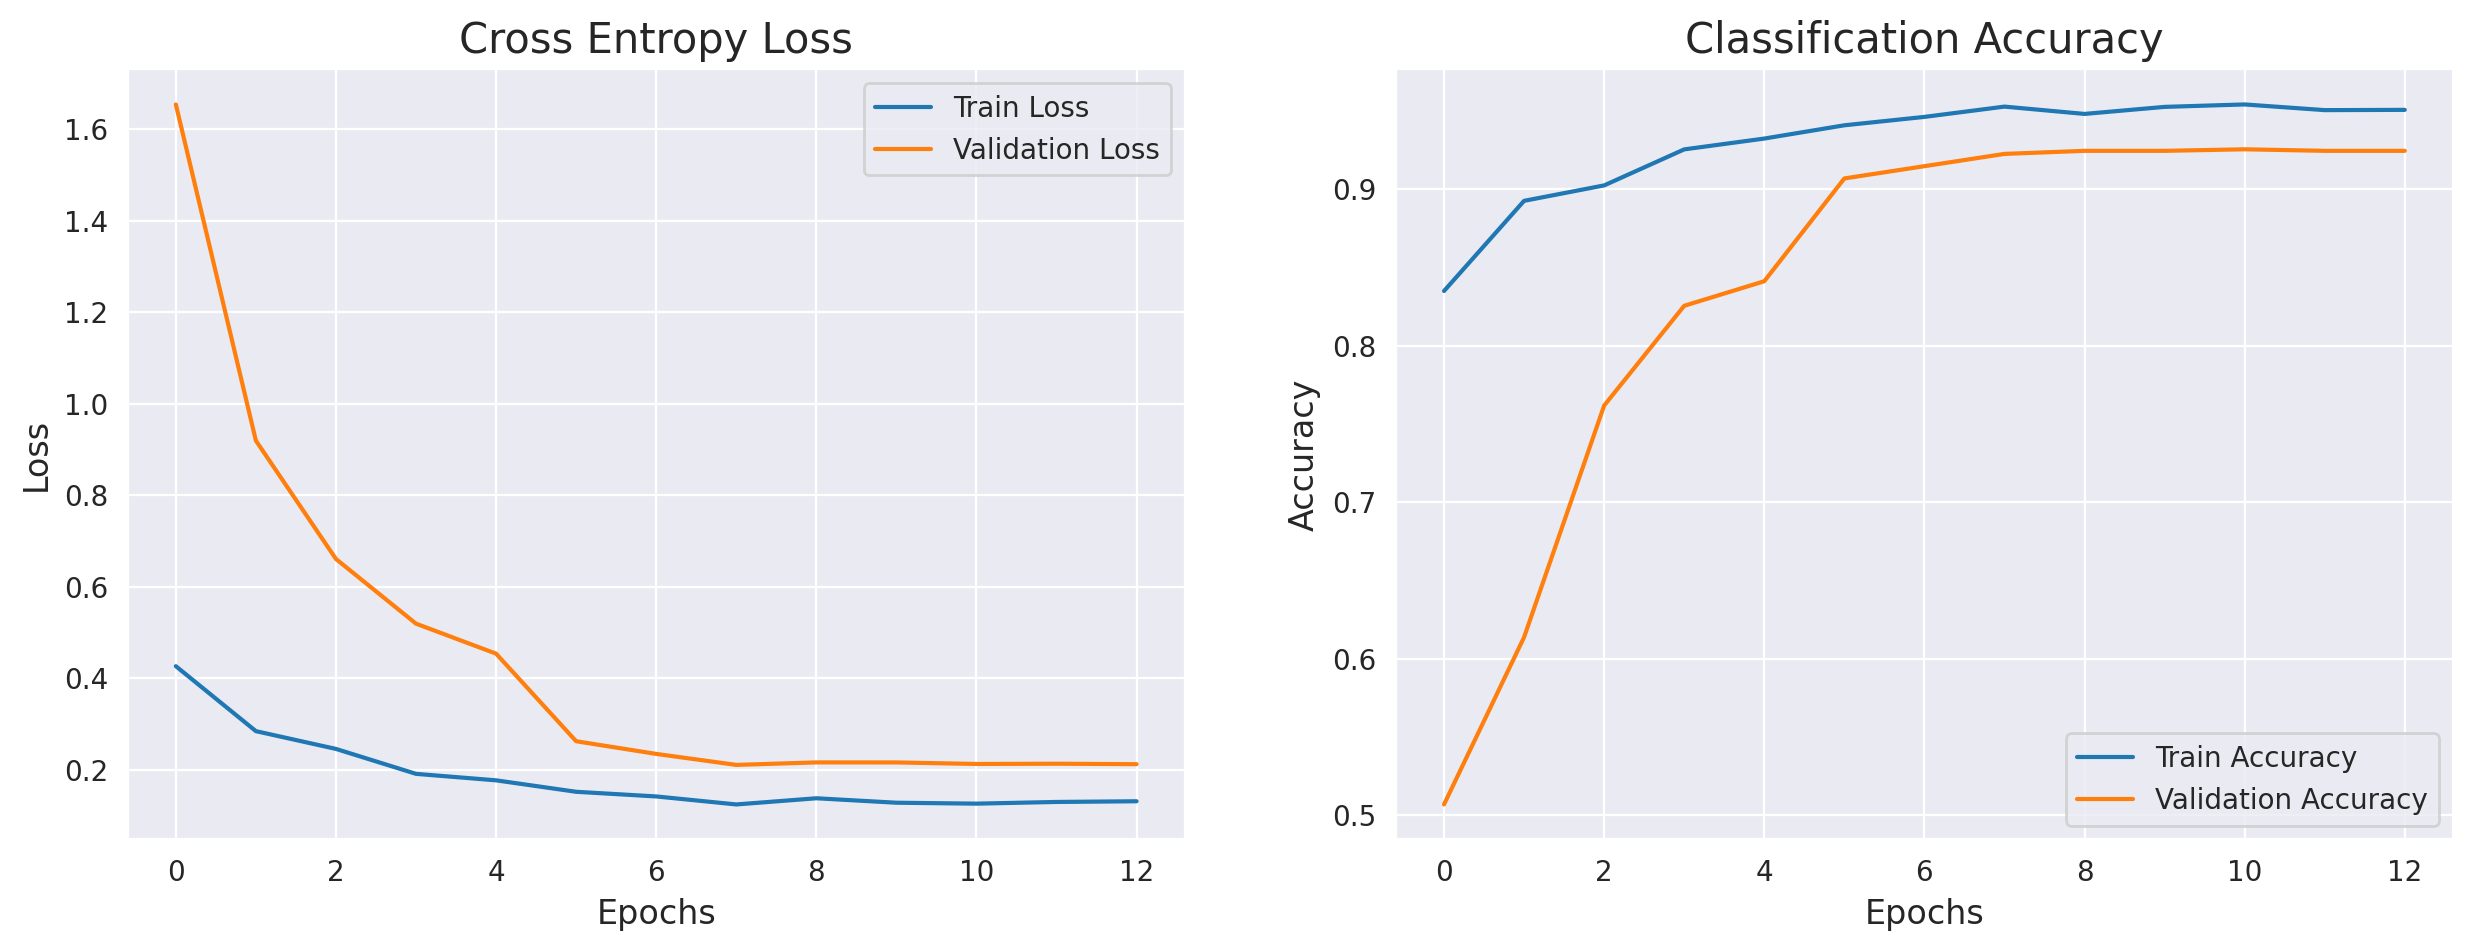


Model Testing 

The accuracy of the model for testing data is: 91.91666841506958
The Loss of the model for testing data is: 0.2286899834871292
Correct predicted classes: 1103
Incorrect predicted classes: 97

Classification Report 

              precision    recall  f1-score   support

      benign       0.90      0.94      0.92       600
   malignant       0.94      0.89      0.92       600

    accuracy                           0.92      1200
   macro avg       0.92      0.92      0.92      1200
weighted avg       0.92      0.92      0.92      1200

Confusion Matrix 



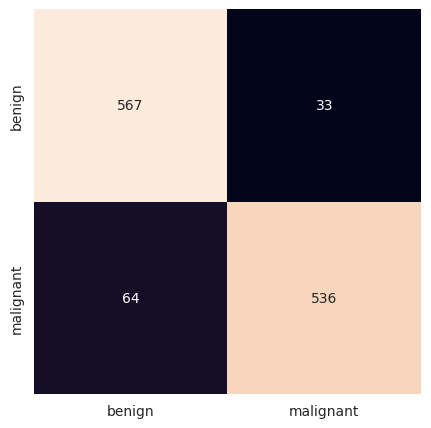

In [ ]:
all_evaluation(eff_model)

# Evaluation Functions

In [ ]:
def all_evaluation(model):

  # graphs
  metrics = pd.DataFrame(model.history.history)

  plt.figure(figsize=(15,5),dpi=200)
  sns.set_style('darkgrid')

  # Loss and Val_loss
  plt.subplot(121)
  plt.title('Cross Entropy Loss',fontsize=15)
  plt.xlabel('Epochs',fontsize=12)
  plt.ylabel('Loss',fontsize=12)
  plt.plot(metrics['loss'], label='Train Loss')
  plt.plot(metrics['val_loss'], label='Validation Loss')
  plt.legend()

  # Accuracy and Val_accuracy
  plt.subplot(122)
  plt.title('Classification Accuracy',fontsize=15)
  plt.xlabel('Epochs',fontsize=12)
  plt.ylabel('Accuracy',fontsize=12)
  plt.plot(metrics['accuracy'], label='Train Accuracy')
  plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
  plt.legend()

  plt.show()

  # testing
  print('\nModel Testing \n')

  loss, acc = model.evaluate(test_gen, verbose=False)

  print('The accuracy of the model for testing data is:', acc*100)
  print('The Loss of the model for testing data is:', loss)

  predicted_class = model.predict(test_gen, verbose=False)
  predicted_class = np.argmax(predicted_class, axis=1)
  actual_class = test_gen.labels

  correct = np.nonzero(predicted_class == actual_class)[0]
  incorrect = np.nonzero(predicted_class != actual_class)[0]

  print("Correct predicted classes:", correct.shape[0])
  print("Incorrect predicted classes:", incorrect.shape[0])

  # classification report
  print('\nClassification Report \n')


  g_dict = test_gen.class_indices
  categories = list(g_dict.keys())

  print(classification_report(actual_class, predicted_class,
                            target_names=categories))

  # confusion matrix
  print('Confusion Matrix \n')

  con_matrix = tf.math.confusion_matrix(
        labels=actual_class,
        predictions=predicted_class,
        num_classes=2)

  plt.figure(figsize=(5,5))
  sns.heatmap(con_matrix, annot=True, fmt='g', cbar=False, xticklabels=categories, yticklabels=categories)
  plt.show()



# Prediction

In [ ]:
print(class_labels)

{0: 'benign', 1: 'malignant'}


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Class labels
class_labels = train_gen.class_indices
class_labels = {v: k for k, v in class_labels.items()}
print(class_labels)
# class_labels = {0: 'benign', 1: 'malignant'}

def predict_image(model, img_path, target_size=(image_h, image_w)):


    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)

    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)  #

    return class_labels[predicted_class], confidence


{0: 'benign', 1: 'malignant'}


In [ ]:
img_path = "/content/images-22.jpeg"
predicted_class, confidence = predict_image(model, img_path)
print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.3f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted Class: malignant, Confidence: 0.538


In [ ]:

model.save('eff_net_b3(benign_malignant)_model_v3.keras')

In [ ]:

!cp -r /content/eff_net_b3_model_v2.keras "/content/drive/MyDrive/Colab Notebooks/MODELS" # saving the model to the drive

In [ ]:
!cp -r /content/eff_net_b3_model_checkpoint.keras "/content/drive/MyDrive/Colab Notebooks/MODELS"